# Base Code
## Contains the model & classifier
#### Done for reduced diabetes

In [33]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='reduced_diabetes'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim_list=[4]
for dim in dim_list:
    print(f"# Result Metrics for Simple Autoencoder+ForestDiffusion for {dataset} dataset")
    print(f'for latent space dimensions={dim}')
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=len(X))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))



# Result Metrics for Simple Autoencoder+ForestDiffusion for reduced_diabetes dataset
for latent space dimensions=4
Recall score (original data): 0.1765
Recall score (generated data): 0.8235
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       151
           1       0.88      0.82      0.85        17

    accuracy                           0.97       168
   macro avg       0.93      0.91      0.92       168
weighted avg       0.97      0.97      0.97       168



# Reduced_Diabetes 
#### Looping through Percentages

In [31]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='reduced_diabetes'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=4
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))



# Result Metrics for Simple Autoencoder(latent space dimensions=4)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 25 % 
Recall score (original data): 0.1765
Recall score (generated data): 0.6471
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       151
           1       0.43      0.18      0.25        17

    accuracy                           0.89       168
   macro avg       0.67      0.57      0.60       168
weighted avg       0.86      0.89      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       151
           1       0.92      0.65      0.76        17

    accuracy                           0.96       168
   macro avg       0.94      0.82      0.87       168
weighted avg       0.96      0.96      0.96       168

# Result Metrics for Simple Autoencoder(latent s

Here is the table displaying the recall scores for both classes (0 and 1) in the generated data for each augmentation ratio:

| Augmentation Ratio (%) | Recall Score (Class 0) | Recall Score (Class 1) |
|------------------------|------------------------|------------------------|
| 25                     | 0.99                   | 0.65                   |
| 50                     | 0.99                   | 0.47                   |
| 75                     | 0.99                   | 0.82                   |
| 100                    | 0.99                   | 0.82                   |
| 125                    | 0.98                   | 0.94                   |
| 150                    | 0.99                   | 0.76                   |
| 175                    | 0.99                   | 0.76                   |
| 200                    | 0.97                   | 0.88                   |
| 225                    | 0.99                   | 0.94                   |
| 250                    | 0.96                   | 0.71                   |
| 275                    | 0.95                   | 0.88                   |
| 300                    | 0.98                   | 0.88                   |

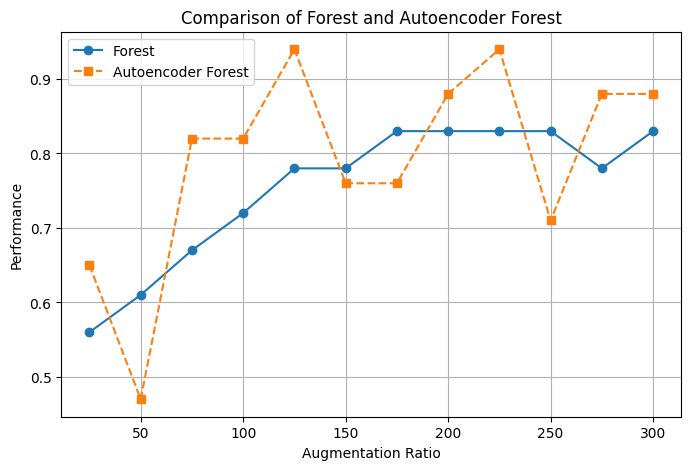

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the image
augmentation_ratio = np.array([25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300])
forest_values = np.array([0.56, 0.61, 0.67, 0.72, 0.78, 0.78, 0.83, 0.83, 0.83, 0.83, 0.78, 0.83])
autoencoder_forest_values = np.array([0.65, 0.47, 0.82, 0.82, 0.94, 0.76, 0.76, 0.88, 0.94, 0.71, 0.88, 0.88])

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(augmentation_ratio, forest_values, marker='o', linestyle='-', label='Forest')
plt.plot(augmentation_ratio, autoencoder_forest_values, marker='s', linestyle='--', label='Autoencoder Forest')

# Labels and title
plt.xlabel("Augmentation Ratio")
plt.ylabel("Performance")
plt.title("Comparison of Forest and Autoencoder Forest")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


Xgboost

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='reduced_diabetes'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=4
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    from xgboost import XGBClassifier  # Replacing RandomForestClassifier with XGBoost
    # Train classifier using XGBoost
    clf_orig = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and evaluate
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))





# Result Metrics for Simple Autoencoder(latent space dimensions=4)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 25 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2353
Recall score (generated data): 0.6471
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       151
           1       0.33      0.24      0.28        17

    accuracy                           0.88       168
   macro avg       0.62      0.59      0.60       168
weighted avg       0.86      0.88      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       151
           1       0.73      0.65      0.69        17

    accuracy                           0.94       168
   macro avg       0.85      0.81      0.83       168
weighted avg       0.94      0.94      0.94       168

# Result Metrics for Simple Autoencoder(latent space dimensions=4)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 50 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2353
Recall score (generated data): 0.5882
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       151
           1       0.33      0.24      0.28        17

    accuracy                           0.88       168
   macro avg       0.62      0.59      0.60       168
weighted avg       0.86      0.88      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       151
           1       0.83      0.59      0.69        17

    accuracy                           0.95       168
   macro avg       0.89      0.79      0.83       168
weighted avg       0.94      0.95      0.94       168

# Result Metrics for Simple Autoencoder(latent space dimensions=4)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 75 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2353
Recall score (generated data): 0.7647
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       151
           1       0.33      0.24      0.28        17

    accuracy                           0.88       168
   macro avg       0.62      0.59      0.60       168
weighted avg       0.86      0.88      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       151
           1       0.76      0.76      0.76        17

    accuracy                           0.95       168
   macro avg       0.87      0.87      0.87       168
weighted avg       0.95      0.95      0.95       168

# Result Metrics for Simple Autoencoder(latent space dimensions=4)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 100 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2353
Recall score (generated data): 0.8235
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       151
           1       0.33      0.24      0.28        17

    accuracy                           0.88       168
   macro avg       0.62      0.59      0.60       168
weighted avg       0.86      0.88      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       151
           1       0.70      0.82      0.76        17

    accuracy                           0.95       168
   macro avg       0.84      0.89      0.86       168
weighted avg       0.95      0.95      0.95       168

# Result Metrics for Simple Autoencoder(latent space dimensions=4)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 125 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2353
Recall score (generated data): 0.9412
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       151
           1       0.33      0.24      0.28        17

    accuracy                           0.88       168
   macro avg       0.62      0.59      0.60       168
weighted avg       0.86      0.88      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       151
           1       0.76      0.94      0.84        17

    accuracy                           0.96       168
   macro avg       0.88      0.95      0.91       168
weighted avg       0.97      0.96      0.97       168

# Result Metrics for Simple Autoencoder(latent space dimensions=4)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 150 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2353
Recall score (generated data): 0.8824
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       151
           1       0.33      0.24      0.28        17

    accuracy                           0.88       168
   macro avg       0.62      0.59      0.60       168
weighted avg       0.86      0.88      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       151
           1       0.75      0.88      0.81        17

    accuracy                           0.96       168
   macro avg       0.87      0.92      0.89       168
weighted avg       0.96      0.96      0.96       168

# Result Metrics for Simple Autoencoder(latent space dimensions=4)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 175 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2353
Recall score (generated data): 0.7647
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       151
           1       0.33      0.24      0.28        17

    accuracy                           0.88       168
   macro avg       0.62      0.59      0.60       168
weighted avg       0.86      0.88      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       151
           1       0.72      0.76      0.74        17

    accuracy                           0.95       168
   macro avg       0.85      0.87      0.86       168
weighted avg       0.95      0.95      0.95       168

# Result Metrics for Simple Autoencoder(latent space dimensions=4)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 200 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2353
Recall score (generated data): 0.9412
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       151
           1       0.33      0.24      0.28        17

    accuracy                           0.88       168
   macro avg       0.62      0.59      0.60       168
weighted avg       0.86      0.88      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       151
           1       0.73      0.94      0.82        17

    accuracy                           0.96       168
   macro avg       0.86      0.95      0.90       168
weighted avg       0.97      0.96      0.96       168

# Result Metrics for Simple Autoencoder(latent space dimensions=4)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 225 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2353
Recall score (generated data): 0.9412
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       151
           1       0.33      0.24      0.28        17

    accuracy                           0.88       168
   macro avg       0.62      0.59      0.60       168
weighted avg       0.86      0.88      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       151
           1       0.84      0.94      0.89        17

    accuracy                           0.98       168
   macro avg       0.92      0.96      0.94       168
weighted avg       0.98      0.98      0.98       168

# Result Metrics for Simple Autoencoder(latent space dimensions=4)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 250 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2353
Recall score (generated data): 0.7647
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       151
           1       0.33      0.24      0.28        17

    accuracy                           0.88       168
   macro avg       0.62      0.59      0.60       168
weighted avg       0.86      0.88      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       151
           1       0.72      0.76      0.74        17

    accuracy                           0.95       168
   macro avg       0.85      0.87      0.86       168
weighted avg       0.95      0.95      0.95       168

# Result Metrics for Simple Autoencoder(latent space dimensions=4)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 275 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2353
Recall score (generated data): 0.8235
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       151
           1       0.33      0.24      0.28        17

    accuracy                           0.88       168
   macro avg       0.62      0.59      0.60       168
weighted avg       0.86      0.88      0.87       168

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       151
           1       0.70      0.82      0.76        17

    accuracy                           0.95       168
   macro avg       0.84      0.89      0.86       168
weighted avg       0.95      0.95      0.95       168

# Result Metrics for Simple Autoencoder(latent space dimensions=4)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 300 % 
Recall score (original data): 0.2353
Recall sco

c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


svm

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Load the dataset
dataset='reduced_diabetes'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=24
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    # Replace -1 with 0 in the target variables
    y_orig = y_orig.replace(-1, 0)
    y_balanced = y_balanced.replace(-1, 0)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Train an SVM classifier
    from sklearn.svm import SVC
    clf_orig = SVC(kernel='rbf', random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)
    
    clf_bal = SVC(kernel='rbf', random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 25 % 
Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent 

c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 75 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 100 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 125 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 150 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 175 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 200 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 225 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 250 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 275 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 300 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

# Diabetes 
#### Looping through Percentages

In [32]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
file_path = f'..\\..\\..\\..\\Extra_Datasets\\creditcard.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=3
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))
    print("xgboost results")
    from xgboost import XGBClassifier  # Replacing RandomForestClassifier with XGBoost
    # Train classifier using XGBoost
    clf_orig = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and evaluate
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))
    print("SVM results")
    # Train an SVM classifier
    from sklearn.svm import SVC
    clf_orig = SVC(kernel='rbf', random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)
    
    clf_bal = SVC(kernel='rbf', random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))





# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for mammography dataset at augmentation ratio = 25 % 
Recall score (original data): 0.5946
Recall score (generated data): 0.6892
Classification Report (original data):
               precision    recall  f1-score   support

          -1       0.99      1.00      0.99      3281
           1       0.92      0.59      0.72        74

    accuracy                           0.99      3355
   macro avg       0.95      0.80      0.86      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

          -1       0.99      1.00      1.00      3281
           1       0.96      0.69      0.80        74

    accuracy                           0.99      3355
   macro avg       0.98      0.84      0.90      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space 

Xgboost

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Load the dataset
file_path = f'..\\..\\..\\..\\Extra_Datasets\\creditcard.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=3
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    # Replace -1 with 0 in the target variables
    y_orig = y_orig.replace(-1, 0)
    y_balanced = y_balanced.replace(-1, 0)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)
    print("xgboost results")
    from xgboost import XGBClassifier  # Replacing RandomForestClassifier with XGBoost
    # Train classifier using XGBoost
    clf_orig = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and evaluate
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))





# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for mammography dataset at augmentation ratio = 25 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7432
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.90      0.74      0.81        74

    accuracy                           0.99      3355
   macro avg       0.95      0.87      0.91      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for mammography dataset at augmentation ratio = 50 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7432
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.92      0.74      0.82        74

    accuracy                           0.99      3355
   macro avg       0.96      0.87      0.91      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for mammography dataset at augmentation ratio = 75 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:48:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:48:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7703
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.88      0.77      0.82        74

    accuracy                           0.99      3355
   macro avg       0.94      0.88      0.91      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for mammography dataset at augmentation ratio = 100 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7568
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.92      0.76      0.83        74

    accuracy                           0.99      3355
   macro avg       0.96      0.88      0.91      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for mammography dataset at augmentation ratio = 125 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7568
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.88      0.76      0.81        74

    accuracy                           0.99      3355
   macro avg       0.93      0.88      0.90      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for mammography dataset at augmentation ratio = 150 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7297
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.92      0.73      0.81        74

    accuracy                           0.99      3355
   macro avg       0.95      0.86      0.90      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for mammography dataset at augmentation ratio = 175 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:50:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:50:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7973
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3281
           1       0.89      0.80      0.84        74

    accuracy                           0.99      3355
   macro avg       0.94      0.90      0.92      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for mammography dataset at augmentation ratio = 200 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7568
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.92      0.76      0.83        74

    accuracy                           0.99      3355
   macro avg       0.96      0.88      0.91      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for mammography dataset at augmentation ratio = 225 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7703
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.93      0.77      0.84        74

    accuracy                           0.99      3355
   macro avg       0.96      0.88      0.92      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for mammography dataset at augmentation ratio = 250 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7838
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3281
           1       0.91      0.78      0.84        74

    accuracy                           0.99      3355
   macro avg       0.95      0.89      0.92      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for mammography dataset at augmentation ratio = 275 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:51:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:51:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7568
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.93      0.76      0.84        74

    accuracy                           0.99      3355
   macro avg       0.96      0.88      0.92      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for mammography dataset at augmentation ratio = 300 % 
Recall score (original data): 0.6757
Recall score (g

c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


SVM

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
file_path = f'..\\..\\..\\..\\Extra_Datasets\\creditcard.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=24
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    # Replace -1 with 0 in the target variables
    y_orig = y_orig.replace(-1, 0)
    y_balanced = y_balanced.replace(-1, 0)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Train an SVM classifier
    from sklearn.svm import SVC
    clf_orig = SVC(kernel='rbf', random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)
    
    clf_bal = SVC(kernel='rbf', random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 25 % 
Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent 

c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 75 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 100 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 125 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 150 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 175 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 200 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 225 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 250 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 275 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for reduced_diabetes dataset at augmentation ratio = 300 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

# Coil_2000 


#### Optimum no. of latent dimensions

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='coil_2000'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
list=[5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45]
for dim in list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at hidden dimensions = {dim} ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    # Replace -1 with 0 in the target variables
    y_orig = y_orig.replace(-1, 0)
    y_balanced = y_balanced.replace(-1, 0)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))



# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for coil_2000 dataset at hidden dimensions = 5 
Recall score (original data): 0.0440
Recall score (generated data): 0.4231
Classification Report (original data):
               precision    recall  f1-score   support

          -1       0.94      0.98      0.96      2765
           1       0.14      0.04      0.07       182

    accuracy                           0.92      2947
   macro avg       0.54      0.51      0.51      2947
weighted avg       0.89      0.92      0.90      2947

Classification Report (generated data):
               precision    recall  f1-score   support

          -1       0.96      0.99      0.97      2765
           1       0.69      0.42      0.52       182

    accuracy                           0.95      2947
   macro avg       0.83      0.71      0.75      2947
weighted avg       0.95      0.95      0.95      2947

# Result Metrics for Simple Autoencoder(latent space dimens

Here is the complete table with recall scores for hidden dimensions up to 45:

| **Hidden Dimensions** | **Recall (-1)** (Original) | **Recall (1)** (Original) | **Recall (-1)** (Generated) | **Recall (1)** (Generated) |
|------------------------|---------------------------|---------------------------|-----------------------------|-----------------------------|
| 5                      | 0.98                      | 0.04                      | 0.99                        | 0.42                        |
| 7                      | 0.98                      | 0.04                      | 0.99                        | 0.43                        |
| 9                      | 0.98                      | 0.04                      | 0.99                        | 0.42                        |
| 11                     | 0.98                      | 0.04                      | 0.99                        | 0.42                        |
| 13                     | 0.98                      | 0.04                      | 0.99                        | 0.42                        |
| 15                     | 0.98                      | 0.04                      | 0.98                        | 0.42                        |
| 17                     | 0.98                      | 0.04                      | 0.99                        | 0.42                        |
| 19                     | 0.98                      | 0.04                      | 0.99                        | 0.42                        |
| 21                     | 0.98                      | 0.04                      | 0.99                        | 0.42                        |
| 23                     | 0.98                      | 0.04                      | 0.99                        | 0.43                        |
| 25                     | 0.98                      | 0.04                      | 0.99                        | 0.43                        |
| 27                     | 0.98                      | 0.04                      | 0.99                        | 0.42                        |
| 29                     | 0.98                      | 0.04                      | 0.99                        | 0.43                        |
| 31                     | 0.98                      | 0.04                      | 0.99                        | 0.43                        |
| 33                     | 0.98                      | 0.04                      | 0.99                        | 0.43                        |
| 35                     | 0.98                      | 0.04                      | 0.99                        | 0.43                        |
| 37                     | 0.98                      | 0.04                      | 0.99                        | 0.43                        |
| 39                     | 0.98                      | 0.04                      | 0.99                        | 0.43                        |
| 41                     | 0.98                      | 0.04                      | 0.99                        | 0.43                        |
| 43                     | 0.98                      | 0.04                      | 0.99                        | 0.43                        |
| 45                     | 0.98                      | 0.04                      | 0.99                        | 0.43                        |



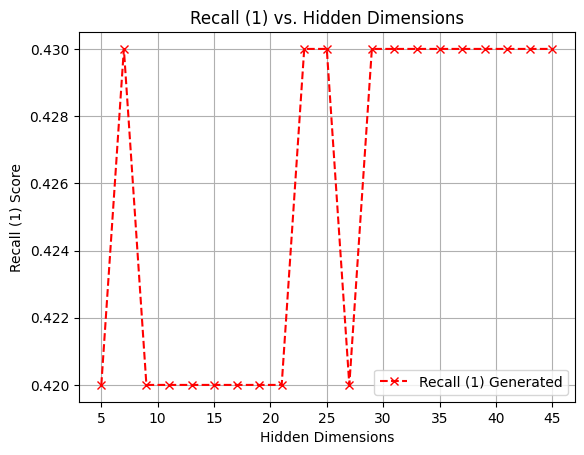

In [5]:
import matplotlib.pyplot as plt

# Data from your table
hidden_dimensions = [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45]
recall_1_original = [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04]
recall_1_generated = [0.42, 0.43, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.43, 0.43, 0.42, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43, 0.43]

# Create the plot
plt.plot(hidden_dimensions, recall_1_generated, marker='x', linestyle='--', color='red', label='Recall (1) Generated')

# Customize the plot
plt.xlabel('Hidden Dimensions')
plt.ylabel('Recall (1) Score')
plt.title('Recall (1) vs. Hidden Dimensions')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

##### So I will use half dimensions as original data

#### Looping through Percentages

In [36]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='coil_2000'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=20
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))



# Result Metrics for Simple Autoencoder(latent space dimensions=20)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 25 % 
Recall score (original data): 0.0440
Recall score (generated data): 0.3681
Classification Report (original data):
               precision    recall  f1-score   support

          -1       0.94      0.98      0.96      2765
           1       0.14      0.04      0.07       182

    accuracy                           0.92      2947
   macro avg       0.54      0.51      0.51      2947
weighted avg       0.89      0.92      0.90      2947

Classification Report (generated data):
               precision    recall  f1-score   support

          -1       0.96      0.99      0.97      2765
           1       0.68      0.37      0.48       182

    accuracy                           0.95      2947
   macro avg       0.82      0.68      0.73      2947
weighted avg       0.94      0.95      0.94      2947

# Result Metrics for Simple Autoencoder(latent space d

Here’s a table showing the recall scores for each class at various augmentation ratios (up to 300%) for the `Simple Autoencoder(latent space dimensions=20)+ForestDiffusion` model applied to the `coil_2000` dataset:

| Augmentation Ratio (%) | Recall (-1) | Recall (1) |
|-------------------------|-------------|------------|
| 25                     | 0.99        | 0.37       |
| 50                     | 0.99        | 0.42       |
| 75                     | 0.99        | 0.40       |
| 100                    | 0.99        | 0.42       |
| 125                    | 0.99        | 0.37       |
| 150                    | 0.99        | 0.38       |
| 175                    | 0.99        | 0.46       |
| 200                    | 0.99        | 0.43       |
| 225                    | 0.99        | 0.45       |
| 250                    | 0.99        | 0.47       |
| 275                    | 0.99        | 0.49       |
| 300                    | 0.99        | 0.50       |



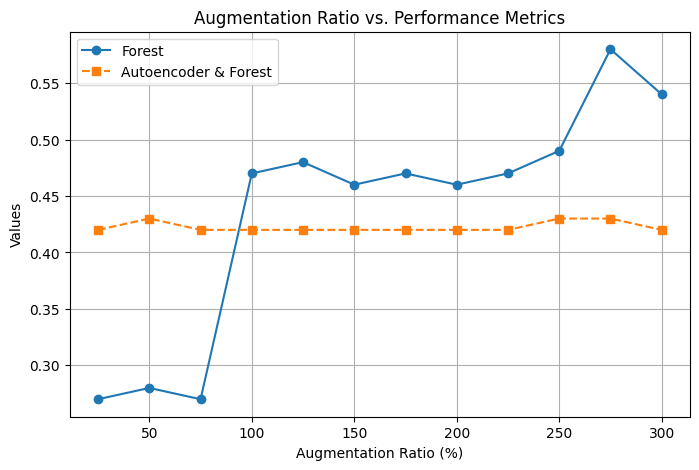

In [2]:
import matplotlib.pyplot as plt

# Data extracted from the image
augmentation_ratio = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
values_1 = [0.27, 0.28, 0.27, 0.47, 0.48, 0.46, 0.47, 0.46, 0.47, 0.49, 0.58, 0.54]  # First column of values
values_2 = [0.42, 0.43, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.43, 0.43, 0.42]  # Second column of values

# Plot the data
plt.figure(figsize=(8, 5))
plt.plot(augmentation_ratio, values_1, marker='o', linestyle='-', label='Forest')
plt.plot(augmentation_ratio, values_2, marker='s', linestyle='--', label='Autoencoder & Forest')

# Labels and title
plt.xlabel("Augmentation Ratio (%)")
plt.ylabel("Values")
plt.title("Augmentation Ratio vs. Performance Metrics")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


Xgboost


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='coil_2000'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=20
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
# Initialize Autoencoder
input_dim = X_tensor.shape[1]
latent_dim = dim  # Low-dimensional space
autoencoder = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=0.01)

# Train the Autoencoder
num_epochs = 2000
batch_size = 32
for epoch in range(num_epochs):
    autoencoder.train()
    for i in range(0, X_tensor.size(0), batch_size):
        batch = X_tensor[i:i+batch_size]
        optimizer.zero_grad()
        encoded, decoded = autoencoder(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
    # if (epoch + 1) % 10 == 0:
    #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Get Latent Space Representation
autoencoder.eval()
with torch.no_grad():
    latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

# Apply ForestDiffusionModel
forest_model = ForestDiffusionModel(
    X=latent_space,
    label_y=None,         # No target labels required for diffusion
    n_t=50,               # Number of timesteps
    duplicate_K=100,      # Augmentation factor
    diffusion_type='flow',# Flow-based diffusion
    n_jobs=-1             # Use all available CPU cores
)

for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    
    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    # Replace -1 with 0 in the target variables
    y_orig = y_orig.replace(-1, 0)
    y_balanced = y_balanced.replace(-1, 0)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    from xgboost import XGBClassifier  # Replacing RandomForestClassifier with XGBoost
    # Train classifier using XGBoost
    clf_orig = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and evaluate
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))





# Result Metrics for Simple Autoencoder(latent space dimensions=20)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 25 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.0824
Recall score (generated data): 0.2582
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2765
           1       0.21      0.08      0.12       182

    accuracy                           0.92      2947
   macro avg       0.58      0.53      0.54      2947
weighted avg       0.90      0.92      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      2765
           1       0.57      0.26      0.35       182

    accuracy                           0.94      2947
   macro avg       0.76      0.62      0.66      2947
weighted avg       0.93      0.94      0.93      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=20)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 50 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.0824
Recall score (generated data): 0.3132
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2765
           1       0.21      0.08      0.12       182

    accuracy                           0.92      2947
   macro avg       0.58      0.53      0.54      2947
weighted avg       0.90      0.92      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      2765
           1       0.62      0.31      0.42       182

    accuracy                           0.95      2947
   macro avg       0.79      0.65      0.69      2947
weighted avg       0.94      0.95      0.94      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=20)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 75 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.0824
Recall score (generated data): 0.2912
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2765
           1       0.21      0.08      0.12       182

    accuracy                           0.92      2947
   macro avg       0.58      0.53      0.54      2947
weighted avg       0.90      0.92      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      2765
           1       0.64      0.29      0.40       182

    accuracy                           0.95      2947
   macro avg       0.80      0.64      0.69      2947
weighted avg       0.94      0.95      0.94      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=20)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 100 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.0824
Recall score (generated data): 0.3132
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2765
           1       0.21      0.08      0.12       182

    accuracy                           0.92      2947
   macro avg       0.58      0.53      0.54      2947
weighted avg       0.90      0.92      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      2765
           1       0.57      0.31      0.40       182

    accuracy                           0.94      2947
   macro avg       0.76      0.65      0.69      2947
weighted avg       0.93      0.94      0.94      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=20)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 125 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.0824
Recall score (generated data): 0.2912
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2765
           1       0.21      0.08      0.12       182

    accuracy                           0.92      2947
   macro avg       0.58      0.53      0.54      2947
weighted avg       0.90      0.92      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      2765
           1       0.64      0.29      0.40       182

    accuracy                           0.95      2947
   macro avg       0.80      0.64      0.69      2947
weighted avg       0.94      0.95      0.94      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=20)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 150 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.0824
Recall score (generated data): 0.3407
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2765
           1       0.21      0.08      0.12       182

    accuracy                           0.92      2947
   macro avg       0.58      0.53      0.54      2947
weighted avg       0.90      0.92      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      2765
           1       0.64      0.34      0.44       182

    accuracy                           0.95      2947
   macro avg       0.80      0.66      0.71      2947
weighted avg       0.94      0.95      0.94      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=20)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 175 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.0824
Recall score (generated data): 0.3407
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2765
           1       0.21      0.08      0.12       182

    accuracy                           0.92      2947
   macro avg       0.58      0.53      0.54      2947
weighted avg       0.90      0.92      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      2765
           1       0.61      0.34      0.44       182

    accuracy                           0.95      2947
   macro avg       0.78      0.66      0.70      2947
weighted avg       0.94      0.95      0.94      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=20)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 200 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.0824
Recall score (generated data): 0.3077
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2765
           1       0.21      0.08      0.12       182

    accuracy                           0.92      2947
   macro avg       0.58      0.53      0.54      2947
weighted avg       0.90      0.92      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      2765
           1       0.64      0.31      0.42       182

    accuracy                           0.95      2947
   macro avg       0.80      0.65      0.69      2947
weighted avg       0.94      0.95      0.94      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=20)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 225 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.0824
Recall score (generated data): 0.3077
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2765
           1       0.21      0.08      0.12       182

    accuracy                           0.92      2947
   macro avg       0.58      0.53      0.54      2947
weighted avg       0.90      0.92      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      2765
           1       0.65      0.31      0.42       182

    accuracy                           0.95      2947
   macro avg       0.80      0.65      0.70      2947
weighted avg       0.94      0.95      0.94      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=20)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 250 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.0824
Recall score (generated data): 0.3297
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2765
           1       0.21      0.08      0.12       182

    accuracy                           0.92      2947
   macro avg       0.58      0.53      0.54      2947
weighted avg       0.90      0.92      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      2765
           1       0.67      0.33      0.44       182

    accuracy                           0.95      2947
   macro avg       0.82      0.66      0.71      2947
weighted avg       0.94      0.95      0.94      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=20)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 275 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.0824
Recall score (generated data): 0.3077
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2765
           1       0.21      0.08      0.12       182

    accuracy                           0.92      2947
   macro avg       0.58      0.53      0.54      2947
weighted avg       0.90      0.92      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      2765
           1       0.62      0.31      0.41       182

    accuracy                           0.95      2947
   macro avg       0.79      0.65      0.69      2947
weighted avg       0.94      0.95      0.94      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=20)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 300 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.0824
Recall score (generated data): 0.3187
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      2765
           1       0.21      0.08      0.12       182

    accuracy                           0.92      2947
   macro avg       0.58      0.53      0.54      2947
weighted avg       0.90      0.92      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      2765
           1       0.60      0.32      0.42       182

    accuracy                           0.94      2947
   macro avg       0.78      0.65      0.69      2947
weighted avg       0.93      0.94      0.94      2947



SVM

In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='coil_2000'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=24
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    # Replace -1 with 0 in the target variables
    y_orig = y_orig.replace(-1, 0)
    y_balanced = y_balanced.replace(-1, 0)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Train an SVM classifier
    from sklearn.svm import SVC
    clf_orig = SVC(kernel='rbf', random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)
    
    clf_bal = SVC(kernel='rbf', random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 25 % 
Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

# Result Metrics for Simple Autoencoder(latent space d

c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 75 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 100 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 125 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 150 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 175 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 200 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 225 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 250 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 275 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for coil_2000 dataset at augmentation ratio = 300 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2765
           1       0.00      0.00      0.00       182

    accuracy                           0.94      2947
   macro avg       0.47      0.50      0.48      2947
weighted avg       0.88      0.94      0.91      2947



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

# Mammography
#### Looping through Percentages

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='Mammography'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=3
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    # Replace -1 with 0 in the target variables
    y_orig = y_orig.replace(-1, 0)
    y_balanced = y_balanced.replace(-1, 0)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))



# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for Mammography dataset at augmentation ratio = 25 % 
Recall score (original data): 0.5946
Recall score (generated data): 0.7027
Classification Report (original data):
               precision    recall  f1-score   support

          -1       0.99      1.00      0.99      3281
           1       0.92      0.59      0.72        74

    accuracy                           0.99      3355
   macro avg       0.95      0.80      0.86      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

          -1       0.99      1.00      1.00      3281
           1       0.98      0.70      0.82        74

    accuracy                           0.99      3355
   macro avg       0.99      0.85      0.91      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space 

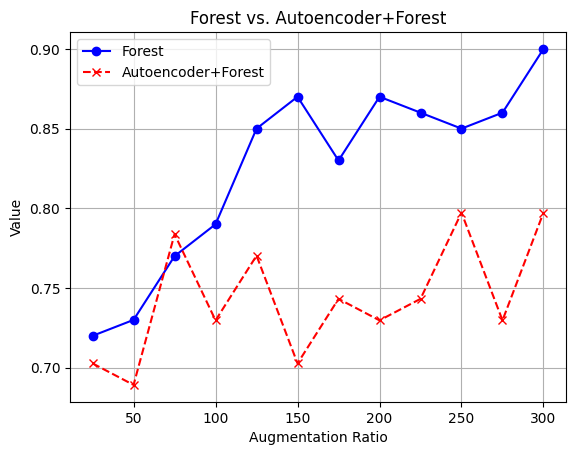

In [6]:
import matplotlib.pyplot as plt

# Data from your table
augmentation_ratios = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
forest_values = [0.72, 0.73, 0.77, 0.79, 0.85, 0.87, 0.83, 0.87, 0.86, 0.85, 0.86, 0.90]
autoencoder_forest_values = [0.7027, 0.6892, 0.7838, 0.7297, 0.7703, 0.7027, 0.7432, 0.7297, 0.7432, 0.7973, 0.7297, 0.7973]

# Create the plot
plt.plot(augmentation_ratios, forest_values, marker='o', linestyle='-', color='blue', label='Forest')
plt.plot(augmentation_ratios, autoencoder_forest_values, marker='x', linestyle='--', color='red', label='Autoencoder+Forest')

# Customize the plot
plt.xlabel('Augmentation Ratio')
plt.ylabel('Value')  # More general label since it's not specified as accuracy or anything else
plt.title('Forest vs. Autoencoder+Forest')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

Xgboost

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='Mammography'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=3
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1]
    # Replace -1 with 0 in the target variables
    y_orig = y_orig.replace(-1, 0)
    y_balanced = y_balanced.replace(-1, 0)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    from xgboost import XGBClassifier  # Replacing RandomForestClassifier with XGBoost
    # Train classifier using XGBoost
    clf_orig = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and evaluate
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))



# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for Mammography dataset at augmentation ratio = 25 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:28:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:28:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7297
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.87      0.73      0.79        74

    accuracy                           0.99      3355
   macro avg       0.93      0.86      0.89      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for Mammography dataset at augmentation ratio = 50 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:28:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:28:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7703
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.85      0.77      0.81        74

    accuracy                           0.99      3355
   macro avg       0.92      0.88      0.90      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for Mammography dataset at augmentation ratio = 75 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:28:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:28:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7973
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3281
           1       0.91      0.80      0.85        74

    accuracy                           0.99      3355
   macro avg       0.95      0.90      0.92      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for Mammography dataset at augmentation ratio = 100 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:29:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:29:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7973
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3281
           1       0.94      0.80      0.86        74

    accuracy                           0.99      3355
   macro avg       0.97      0.90      0.93      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for Mammography dataset at augmentation ratio = 125 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:29:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:29:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7973
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3281
           1       0.92      0.80      0.86        74

    accuracy                           0.99      3355
   macro avg       0.96      0.90      0.93      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for Mammography dataset at augmentation ratio = 150 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7297
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.93      0.73      0.82        74

    accuracy                           0.99      3355
   macro avg       0.96      0.86      0.91      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for Mammography dataset at augmentation ratio = 175 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.8108
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3281
           1       0.86      0.81      0.83        74

    accuracy                           0.99      3355
   macro avg       0.93      0.90      0.91      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for Mammography dataset at augmentation ratio = 200 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7568
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.93      0.76      0.84        74

    accuracy                           0.99      3355
   macro avg       0.96      0.88      0.92      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for Mammography dataset at augmentation ratio = 225 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:30:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:31:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7838
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3281
           1       0.91      0.78      0.84        74

    accuracy                           0.99      3355
   macro avg       0.95      0.89      0.92      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for Mammography dataset at augmentation ratio = 250 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.8378
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3281
           1       0.95      0.84      0.89        74

    accuracy                           1.00      3355
   macro avg       0.98      0.92      0.94      3355
weighted avg       1.00      1.00      1.00      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for Mammography dataset at augmentation ratio = 275 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6757
Recall score (generated data): 0.7568
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.85      0.68      0.75        74

    accuracy                           0.99      3355
   macro avg       0.92      0.84      0.87      3355
weighted avg       0.99      0.99      0.99      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3281
           1       0.86      0.76      0.81        74

    accuracy                           0.99      3355
   macro avg       0.93      0.88      0.90      3355
weighted avg       0.99      0.99      0.99      3355

# Result Metrics for Simple Autoencoder(latent space dimensions=3)+ForestDiffusion for Mammography dataset at augmentation ratio = 300 % 
Recall score (original data): 0.6757
Recall score (g

c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:32:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:32:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


SVM

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='Mammography'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path


# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=24
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    # Replace -1 with 0 in the target variables
    y_orig = y_orig.replace(-1, 0)
    y_balanced = y_balanced.replace(-1, 0)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Train an SVM classifier
    from sklearn.svm import SVC
    clf_orig = SVC(kernel='rbf', random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)
    
    clf_bal = SVC(kernel='rbf', random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for Mammography dataset at augmentation ratio = 25 % 
Recall score (original data): 0.4189
Recall score (generated data): 0.4459
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.94      0.42      0.58        74

    accuracy                           0.99      3355
   macro avg       0.96      0.71      0.79      3355
weighted avg       0.99      0.99      0.98      3355

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3281
           1       0.94      0.45      0.61        74

    accuracy                           0.99      3355
   macro avg       0.97      0.72      0.80      3355
weighted avg       0.99      0.99      0.98      3355

# Result Metrics for Simple Autoencoder(latent space

# Reduced Cardio Train
#### Looping through Percentages

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='reduced_cardio_train'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=5
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))



# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 25 % 
Recall score (original data): 0.0840
Recall score (generated data): 0.6950
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      0.98      0.94     10517
           1       0.37      0.08      0.14      1190

    accuracy                           0.89     11707
   macro avg       0.64      0.53      0.54     11707
weighted avg       0.85      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     10517
           1       0.88      0.69      0.78      1190

    accuracy                           0.96     11707
   macro avg       0.92      0.84      0.88     11707
weighted avg       0.96      0.96      0.96     11707

# Result Metrics for Simple Autoencoder(late

XGboost Classifier

In [ ]:
import numpy as np  
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from xgboost import XGBClassifier  # Replacing RandomForestClassifier with XGBoost

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Load the dataset
dataset = 'reduced_cardio_train'
file_path = f'../../../Datasets/Original Data/{dataset}.csv'
data = pd.read_csv(file_path)

# Separate features and target
X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1]

real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]
y = real_minortiy.iloc[:, -1]

# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled = scaler.fit_transform(X_orig)

# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim = 5
multiplier_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]

for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,
        n_t=50,
        duplicate_K=100,
        diffusion_type='flow',
        n_jobs=-1
    )

    # Generate synthetic samples
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier * len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()
    
    synthetic_features = scaler.inverse_transform(synthetic_features)
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)
    synthetic_df['target'] = 1

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Split the dataset
    X_balanced = augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Train classifier using XGBoost
    clf_orig = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and evaluate
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))



# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 25 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:43:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:43:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.1034
Recall score (generated data): 0.2445
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     10517
           1       0.40      0.10      0.16      1190

    accuracy                           0.89     11707
   macro avg       0.65      0.54      0.55     11707
weighted avg       0.86      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     10517
           1       0.72      0.24      0.36      1190

    accuracy                           0.91     11707
   macro avg       0.82      0.62      0.66     11707
weighted avg       0.90      0.91      0.89     11707

# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 50 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:50:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:50:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.1034
Recall score (generated data): 0.2597
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     10517
           1       0.40      0.10      0.16      1190

    accuracy                           0.89     11707
   macro avg       0.65      0.54      0.55     11707
weighted avg       0.86      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     10517
           1       0.70      0.26      0.38      1190

    accuracy                           0.91     11707
   macro avg       0.81      0.62      0.67     11707
weighted avg       0.90      0.91      0.89     11707

# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 75 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:58:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:58:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.1034
Recall score (generated data): 0.2176
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     10517
           1       0.40      0.10      0.16      1190

    accuracy                           0.89     11707
   macro avg       0.65      0.54      0.55     11707
weighted avg       0.86      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     10517
           1       0.72      0.22      0.33      1190

    accuracy                           0.91     11707
   macro avg       0.82      0.60      0.64     11707
weighted avg       0.90      0.91      0.89     11707

# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 100 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:06:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.1034
Recall score (generated data): 0.2555
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     10517
           1       0.40      0.10      0.16      1190

    accuracy                           0.89     11707
   macro avg       0.65      0.54      0.55     11707
weighted avg       0.86      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     10517
           1       0.70      0.26      0.37      1190

    accuracy                           0.91     11707
   macro avg       0.81      0.62      0.66     11707
weighted avg       0.90      0.91      0.89     11707

# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 125 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.1034
Recall score (generated data): 0.2462
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     10517
           1       0.40      0.10      0.16      1190

    accuracy                           0.89     11707
   macro avg       0.65      0.54      0.55     11707
weighted avg       0.86      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     10517
           1       0.70      0.25      0.36      1190

    accuracy                           0.91     11707
   macro avg       0.81      0.62      0.66     11707
weighted avg       0.90      0.91      0.89     11707

# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 150 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.1034
Recall score (generated data): 0.2395
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     10517
           1       0.40      0.10      0.16      1190

    accuracy                           0.89     11707
   macro avg       0.65      0.54      0.55     11707
weighted avg       0.86      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     10517
           1       0.69      0.24      0.36      1190

    accuracy                           0.91     11707
   macro avg       0.81      0.61      0.65     11707
weighted avg       0.90      0.91      0.89     11707

# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 175 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.1034
Recall score (generated data): 0.2479
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     10517
           1       0.40      0.10      0.16      1190

    accuracy                           0.89     11707
   macro avg       0.65      0.54      0.55     11707
weighted avg       0.86      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     10517
           1       0.75      0.25      0.37      1190

    accuracy                           0.92     11707
   macro avg       0.84      0.62      0.66     11707
weighted avg       0.90      0.92      0.90     11707

# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 200 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.1034
Recall score (generated data): 0.2681
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     10517
           1       0.40      0.10      0.16      1190

    accuracy                           0.89     11707
   macro avg       0.65      0.54      0.55     11707
weighted avg       0.86      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     10517
           1       0.70      0.27      0.39      1190

    accuracy                           0.91     11707
   macro avg       0.81      0.63      0.67     11707
weighted avg       0.90      0.91      0.90     11707

# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 225 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.1034
Recall score (generated data): 0.2807
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     10517
           1       0.40      0.10      0.16      1190

    accuracy                           0.89     11707
   macro avg       0.65      0.54      0.55     11707
weighted avg       0.86      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     10517
           1       0.72      0.28      0.40      1190

    accuracy                           0.92     11707
   macro avg       0.82      0.63      0.68     11707
weighted avg       0.90      0.92      0.90     11707

# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 250 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.1034
Recall score (generated data): 0.2546
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     10517
           1       0.40      0.10      0.16      1190

    accuracy                           0.89     11707
   macro avg       0.65      0.54      0.55     11707
weighted avg       0.86      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     10517
           1       0.68      0.25      0.37      1190

    accuracy                           0.91     11707
   macro avg       0.80      0.62      0.66     11707
weighted avg       0.90      0.91      0.89     11707

# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 275 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.1034
Recall score (generated data): 0.2588
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     10517
           1       0.40      0.10      0.16      1190

    accuracy                           0.89     11707
   macro avg       0.65      0.54      0.55     11707
weighted avg       0.86      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     10517
           1       0.73      0.26      0.38      1190

    accuracy                           0.92     11707
   macro avg       0.83      0.62      0.67     11707
weighted avg       0.90      0.92      0.90     11707

# Result Metrics for Simple Autoencoder(latent space dimensions=5)+ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 300 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.1034
Recall score (generated data): 0.2437
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     10517
           1       0.40      0.10      0.16      1190

    accuracy                           0.89     11707
   macro avg       0.65      0.54      0.55     11707
weighted avg       0.86      0.89      0.86     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     10517
           1       0.71      0.24      0.36      1190

    accuracy                           0.91     11707
   macro avg       0.81      0.62      0.66     11707
weighted avg       0.90      0.91      0.89     11707



svm


In [1]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel 

In [ ]:
# Train an SVM classifier
    from sklearn.svm import SVC
    clf_orig = SVC(kernel='rbf', random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)
    
    clf_bal = SVC(kernel='rbf', random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


In [2]:
 # Assuming ForestDiffusionModel is available
import numpy as np  
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Load the dataset
dataset = 'reduced_cardio_train'
file_path = f'../../../Datasets/Original Data/{dataset}.csv'
data = pd.read_csv(file_path)

# Separate features and target
X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1]

real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Features
y = real_minortiy.iloc[:, -1]   # Target variable

# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled = scaler.fit_transform(X_orig)

# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim = 5
multiplier_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]

for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder (latent space={dim}) + ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)}%")
    
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            _, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,
        n_t=50,
        duplicate_K=100,
        diffusion_type='flow',
        n_jobs=-1
    )

    # Generate synthetic samples
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier * len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()
    
    # Scale it back
    synthetic_features = scaler.inverse_transform(synthetic_features)
    
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)
    synthetic_df['target'] = 1
    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Split the dataset
    X_balanced = augmented_dataset.iloc[:, :-1]
    y_balanced = augmented_dataset.iloc[:, -1]
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Train an SVM classifier
    clf_orig = SVC(kernel='rbf', random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)
    
    clf_bal = SVC(kernel='rbf', random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


# Result Metrics for Simple Autoencoder (latent space=5) + ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 25%
Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

# Result Metrics for Simple Autoencoder (latent space=

c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

# Result Metrics for Simple Autoencoder (latent space=5) + ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 75%


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

# Result Metrics for Simple Autoencoder (latent space=5) + ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 100%


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

# Result Metrics for Simple Autoencoder (latent space=5) + ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 125%


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

# Result Metrics for Simple Autoencoder (latent space=5) + ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 150%


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

# Result Metrics for Simple Autoencoder (latent space=5) + ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 175%


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

# Result Metrics for Simple Autoencoder (latent space=5) + ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 200%


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

# Result Metrics for Simple Autoencoder (latent space=5) + ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 225%


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

# Result Metrics for Simple Autoencoder (latent space=5) + ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 250%


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

# Result Metrics for Simple Autoencoder (latent space=5) + ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 275%


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

# Result Metrics for Simple Autoencoder (latent space=5) + ForestDiffusion for reduced_cardio_train dataset at augmentation ratio = 300%


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     10517
           1       0.00      0.00      0.00      1190

    accuracy                           0.90     11707
   macro avg       0.45      0.50      0.47     11707
weighted avg       0.81      0.90      0.85     11707



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

# Reduced Smart Grid Stability Dataset 
#### Looping through Percentages

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='reduced_smart_grid_stability'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=6
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))



# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 25 % 
Recall score (original data): 0.4338
Recall score (generated data): 0.8344
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      1912
           1       0.96      0.43      0.60       302

    accuracy                           0.92      2214
   macro avg       0.94      0.72      0.78      2214
weighted avg       0.92      0.92      0.91      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1912
           1       0.99      0.83      0.90       302

    accuracy                           0.98      2214
   macro avg       0.98      0.92      0.95      2214
weighted avg       0.98      0.98      0.98      2214

# Result Metrics for Simple Autoenco

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='reduced_smart_grid_stability'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=6
multiplier_list=[2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 275 % 
Recall score (original data): 0.4338
Recall score (generated data): 0.8907
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      1912
           1       0.96      0.43      0.60       302

    accuracy                           0.92      2214
   macro avg       0.94      0.72      0.78      2214
weighted avg       0.92      0.92      0.91      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1912
           1       0.92      0.89      0.91       302

    accuracy                           0.98      2214
   macro avg       0.95      0.94      0.95      2214
weighted avg       0.97      0.98      0.97      2214

# Result Metrics for Simple Autoenc

Xgboost

In [1]:
import numpy as np  
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from xgboost import XGBClassifier  # Replacing RandomForestClassifier with XGBoost

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Load the dataset
dataset = 'reduced_smart_grid_stability'
file_path = f'../../../Datasets/Original Data/{dataset}.csv'
data = pd.read_csv(file_path)

# Separate features and target
X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1]

real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]
y = real_minortiy.iloc[:, -1]

# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled = scaler.fit_transform(X_orig)

# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim = 6
multiplier_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]

for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,
        n_t=50,
        duplicate_K=100,
        diffusion_type='flow',
        n_jobs=-1
    )

    # Generate synthetic samples
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier * len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()
    
    synthetic_features = scaler.inverse_transform(synthetic_features)
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)
    synthetic_df['target'] = 1

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Split the dataset
    X_balanced = augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Train classifier using XGBoost
    clf_orig = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and evaluate
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 25 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:56:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:56:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6854
Recall score (generated data): 0.9172
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1912
           1       0.93      0.69      0.79       302

    accuracy                           0.95      2214
   macro avg       0.94      0.84      0.88      2214
weighted avg       0.95      0.95      0.95      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1912
           1       0.94      0.92      0.93       302

    accuracy                           0.98      2214
   macro avg       0.96      0.95      0.96      2214
weighted avg       0.98      0.98      0.98      2214

# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 50 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:58:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:58:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6854
Recall score (generated data): 0.9205
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1912
           1       0.93      0.69      0.79       302

    accuracy                           0.95      2214
   macro avg       0.94      0.84      0.88      2214
weighted avg       0.95      0.95      0.95      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1912
           1       0.95      0.92      0.93       302

    accuracy                           0.98      2214
   macro avg       0.97      0.96      0.96      2214
weighted avg       0.98      0.98      0.98      2214

# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 75 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:00:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:00:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6854
Recall score (generated data): 0.9073
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1912
           1       0.93      0.69      0.79       302

    accuracy                           0.95      2214
   macro avg       0.94      0.84      0.88      2214
weighted avg       0.95      0.95      0.95      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1912
           1       0.94      0.91      0.93       302

    accuracy                           0.98      2214
   macro avg       0.97      0.95      0.96      2214
weighted avg       0.98      0.98      0.98      2214

# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 100 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:02:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:02:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6854
Recall score (generated data): 0.9172
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1912
           1       0.93      0.69      0.79       302

    accuracy                           0.95      2214
   macro avg       0.94      0.84      0.88      2214
weighted avg       0.95      0.95      0.95      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1912
           1       0.94      0.92      0.93       302

    accuracy                           0.98      2214
   macro avg       0.96      0.95      0.96      2214
weighted avg       0.98      0.98      0.98      2214

# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 125 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:04:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:04:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6854
Recall score (generated data): 0.9139
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1912
           1       0.93      0.69      0.79       302

    accuracy                           0.95      2214
   macro avg       0.94      0.84      0.88      2214
weighted avg       0.95      0.95      0.95      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1912
           1       0.94      0.91      0.92       302

    accuracy                           0.98      2214
   macro avg       0.96      0.95      0.96      2214
weighted avg       0.98      0.98      0.98      2214

# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 150 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:06:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:06:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6854
Recall score (generated data): 0.9470
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1912
           1       0.93      0.69      0.79       302

    accuracy                           0.95      2214
   macro avg       0.94      0.84      0.88      2214
weighted avg       0.95      0.95      0.95      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1912
           1       0.93      0.95      0.94       302

    accuracy                           0.98      2214
   macro avg       0.96      0.97      0.96      2214
weighted avg       0.98      0.98      0.98      2214

# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 175 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6854
Recall score (generated data): 0.9404
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1912
           1       0.93      0.69      0.79       302

    accuracy                           0.95      2214
   macro avg       0.94      0.84      0.88      2214
weighted avg       0.95      0.95      0.95      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1912
           1       0.93      0.94      0.93       302

    accuracy                           0.98      2214
   macro avg       0.96      0.96      0.96      2214
weighted avg       0.98      0.98      0.98      2214

# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 200 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:10:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:10:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6854
Recall score (generated data): 0.9272
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1912
           1       0.93      0.69      0.79       302

    accuracy                           0.95      2214
   macro avg       0.94      0.84      0.88      2214
weighted avg       0.95      0.95      0.95      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1912
           1       0.92      0.93      0.92       302

    accuracy                           0.98      2214
   macro avg       0.95      0.96      0.96      2214
weighted avg       0.98      0.98      0.98      2214

# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 225 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:12:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6854
Recall score (generated data): 0.9536
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1912
           1       0.93      0.69      0.79       302

    accuracy                           0.95      2214
   macro avg       0.94      0.84      0.88      2214
weighted avg       0.95      0.95      0.95      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1912
           1       0.95      0.95      0.95       302

    accuracy                           0.99      2214
   macro avg       0.97      0.97      0.97      2214
weighted avg       0.99      0.99      0.99      2214

# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 250 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:14:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6854
Recall score (generated data): 0.9570
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1912
           1       0.93      0.69      0.79       302

    accuracy                           0.95      2214
   macro avg       0.94      0.84      0.88      2214
weighted avg       0.95      0.95      0.95      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1912
           1       0.93      0.96      0.94       302

    accuracy                           0.98      2214
   macro avg       0.96      0.97      0.97      2214
weighted avg       0.98      0.98      0.98      2214

# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 275 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:16:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6854
Recall score (generated data): 0.9371
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1912
           1       0.93      0.69      0.79       302

    accuracy                           0.95      2214
   macro avg       0.94      0.84      0.88      2214
weighted avg       0.95      0.95      0.95      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1912
           1       0.94      0.94      0.94       302

    accuracy                           0.98      2214
   macro avg       0.96      0.96      0.96      2214
weighted avg       0.98      0.98      0.98      2214

# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 300 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.6854
Recall score (generated data): 0.9272
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1912
           1       0.93      0.69      0.79       302

    accuracy                           0.95      2214
   macro avg       0.94      0.84      0.88      2214
weighted avg       0.95      0.95      0.95      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1912
           1       0.93      0.93      0.93       302

    accuracy                           0.98      2214
   macro avg       0.96      0.96      0.96      2214
weighted avg       0.98      0.98      0.98      2214



svm

In [4]:
import numpy as np  
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from xgboost import XGBClassifier  # Replacing RandomForestClassifier with XGBoost

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Load the dataset
dataset = 'reduced_smart_grid_stability'
file_path = f'../../../Datasets/Original Data/{dataset}.csv'
data = pd.read_csv(file_path)

# Separate features and target
X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1]

real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]
y = real_minortiy.iloc[:, -1]

# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled = scaler.fit_transform(X_orig)

# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim = 6
multiplier_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]

for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,
        n_t=50,
        duplicate_K=100,
        diffusion_type='flow',
        n_jobs=-1
    )

    # Generate synthetic samples
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier * len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()
    
    synthetic_features = scaler.inverse_transform(synthetic_features)
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)
    synthetic_df['target'] = 1

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Split the dataset
    X_balanced = augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Train an SVM classifier
    from sklearn.svm import SVC
    clf_orig = SVC(kernel='rbf', random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)
    
    clf_bal = SVC(kernel='rbf', random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))



# Result Metrics for Simple Autoencoder(latent space dimensions=6)+ForestDiffusion for reduced_smart_grid_stability dataset at augmentation ratio = 25 % 
Recall score (original data): 0.2119
Recall score (generated data): 0.3709
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      1912
           1       0.98      0.21      0.35       302

    accuracy                           0.89      2214
   macro avg       0.94      0.61      0.64      2214
weighted avg       0.90      0.89      0.86      2214

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      1912
           1       0.93      0.37      0.53       302

    accuracy                           0.91      2214
   macro avg       0.92      0.68      0.74      2214
weighted avg       0.91      0.91      0.89      2214

# Result Metrics for Simple Autoenco

# Oil Dataset 
#### Looping through Percentages

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='oil'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=24
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    # Replace -1 with 0 in the target variables
    y_orig = y_orig.replace(-1, 0)
    y_balanced = y_balanced.replace(-1, 0)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 25 % 
Recall score (original data): 0.2727
Recall score (generated data): 0.6364
Classification Report (original data):
               precision    recall  f1-score   support

          -1       0.97      0.99      0.98       271
           1       0.60      0.27      0.38        11

    accuracy                           0.96       282
   macro avg       0.79      0.63      0.68       282
weighted avg       0.96      0.96      0.96       282

Classification Report (generated data):
               precision    recall  f1-score   support

          -1       0.99      1.00      0.99       271
           1       0.88      0.64      0.74        11

    accuracy                           0.98       282
   macro avg       0.93      0.82      0.86       282
weighted avg       0.98      0.98      0.98       282

# Result Metrics for Simple Autoencoder(latent space dimensi

Xgboost

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='oil'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=24
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    # Replace -1 with 0 in the target variables
    y_orig = y_orig.replace(-1, 0)
    y_balanced = y_balanced.replace(-1, 0)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    from xgboost import XGBClassifier  # Replacing RandomForestClassifier with XGBoost
    # Train classifier using XGBoost
    clf_orig = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and evaluate
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))



# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 25 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2727
Recall score (generated data): 0.7273
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       271
           1       0.50      0.27      0.35        11

    accuracy                           0.96       282
   macro avg       0.74      0.63      0.67       282
weighted avg       0.95      0.96      0.96       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       271
           1       0.89      0.73      0.80        11

    accuracy                           0.99       282
   macro avg       0.94      0.86      0.90       282
weighted avg       0.99      0.99      0.99       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 50 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:06:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2727
Recall score (generated data): 0.8182
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       271
           1       0.50      0.27      0.35        11

    accuracy                           0.96       282
   macro avg       0.74      0.63      0.67       282
weighted avg       0.95      0.96      0.96       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       271
           1       0.82      0.82      0.82        11

    accuracy                           0.99       282
   macro avg       0.91      0.91      0.91       282
weighted avg       0.99      0.99      0.99       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 75 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:09:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:09:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2727
Recall score (generated data): 0.6364
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       271
           1       0.50      0.27      0.35        11

    accuracy                           0.96       282
   macro avg       0.74      0.63      0.67       282
weighted avg       0.95      0.96      0.96       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       271
           1       0.88      0.64      0.74        11

    accuracy                           0.98       282
   macro avg       0.93      0.82      0.86       282
weighted avg       0.98      0.98      0.98       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 100 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:12:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:12:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2727
Recall score (generated data): 0.5455
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       271
           1       0.50      0.27      0.35        11

    accuracy                           0.96       282
   macro avg       0.74      0.63      0.67       282
weighted avg       0.95      0.96      0.96       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       271
           1       1.00      0.55      0.71        11

    accuracy                           0.98       282
   macro avg       0.99      0.77      0.85       282
weighted avg       0.98      0.98      0.98       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 125 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:14:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:14:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2727
Recall score (generated data): 0.6364
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       271
           1       0.50      0.27      0.35        11

    accuracy                           0.96       282
   macro avg       0.74      0.63      0.67       282
weighted avg       0.95      0.96      0.96       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       271
           1       0.88      0.64      0.74        11

    accuracy                           0.98       282
   macro avg       0.93      0.82      0.86       282
weighted avg       0.98      0.98      0.98       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 150 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:17:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:17:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2727
Recall score (generated data): 0.7273
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       271
           1       0.50      0.27      0.35        11

    accuracy                           0.96       282
   macro avg       0.74      0.63      0.67       282
weighted avg       0.95      0.96      0.96       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       271
           1       0.89      0.73      0.80        11

    accuracy                           0.99       282
   macro avg       0.94      0.86      0.90       282
weighted avg       0.99      0.99      0.99       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 175 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:20:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:20:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2727
Recall score (generated data): 0.7273
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       271
           1       0.50      0.27      0.35        11

    accuracy                           0.96       282
   macro avg       0.74      0.63      0.67       282
weighted avg       0.95      0.96      0.96       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       271
           1       1.00      0.73      0.84        11

    accuracy                           0.99       282
   macro avg       0.99      0.86      0.92       282
weighted avg       0.99      0.99      0.99       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 200 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:22:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:22:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2727
Recall score (generated data): 0.4545
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       271
           1       0.50      0.27      0.35        11

    accuracy                           0.96       282
   macro avg       0.74      0.63      0.67       282
weighted avg       0.95      0.96      0.96       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       271
           1       0.83      0.45      0.59        11

    accuracy                           0.98       282
   macro avg       0.91      0.73      0.79       282
weighted avg       0.97      0.98      0.97       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 225 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2727
Recall score (generated data): 0.7273
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       271
           1       0.50      0.27      0.35        11

    accuracy                           0.96       282
   macro avg       0.74      0.63      0.67       282
weighted avg       0.95      0.96      0.96       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       271
           1       0.89      0.73      0.80        11

    accuracy                           0.99       282
   macro avg       0.94      0.86      0.90       282
weighted avg       0.99      0.99      0.99       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 250 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:28:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:28:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2727
Recall score (generated data): 0.7273
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       271
           1       0.50      0.27      0.35        11

    accuracy                           0.96       282
   macro avg       0.74      0.63      0.67       282
weighted avg       0.95      0.96      0.96       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       271
           1       0.73      0.73      0.73        11

    accuracy                           0.98       282
   macro avg       0.86      0.86      0.86       282
weighted avg       0.98      0.98      0.98       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 275 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:30:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.2727
Recall score (generated data): 0.5455
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       271
           1       0.50      0.27      0.35        11

    accuracy                           0.96       282
   macro avg       0.74      0.63      0.67       282
weighted avg       0.95      0.96      0.96       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       271
           1       0.75      0.55      0.63        11

    accuracy                           0.98       282
   macro avg       0.87      0.77      0.81       282
weighted avg       0.97      0.98      0.97       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 300 % 
Recall score (original data): 0.2727
Recall score (generate

c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


svm


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='oil'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=24
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    # Replace -1 with 0 in the target variables
    y_orig = y_orig.replace(-1, 0)
    y_balanced = y_balanced.replace(-1, 0)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Train an SVM classifier
    from sklearn.svm import SVC
    clf_orig = SVC(kernel='rbf', random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)
    
    clf_bal = SVC(kernel='rbf', random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 25 % 
Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

# Result Metrics for Simple Autoencoder(latent space dimensi

c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 75 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 100 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 125 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0909
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       1.00      0.09      0.17        11

    accuracy                           0.96       282
   macro avg       0.98      0.55      0.57       282
weighted avg       0.97      0.96      0.95       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 150 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0909
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       271
           1       0.25      0.09      0.13        11

    accuracy                           0.95       282
   macro avg       0.61      0.54      0.55       282
weighted avg       0.94      0.95      0.94       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 175 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0909
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       271
           1       0.33      0.09      0.14        11

    accuracy                           0.96       282
   macro avg       0.65      0.54      0.56       282
weighted avg       0.94      0.96      0.95       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 200 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 225 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0909
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       271
           1       0.33      0.09      0.14        11

    accuracy                           0.96       282
   macro avg       0.65      0.54      0.56       282
weighted avg       0.94      0.96      0.95       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 250 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0909
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       271
           1       0.33      0.09      0.14        11

    accuracy                           0.96       282
   macro avg       0.65      0.54      0.56       282
weighted avg       0.94      0.96      0.95       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 275 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0909
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       271
           1       0.25      0.09      0.13        11

    accuracy                           0.95       282
   macro avg       0.61      0.54      0.55       282
weighted avg       0.94      0.95      0.94       282

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 300 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0909
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.00      0.00      0.00        11

    accuracy                           0.96       282
   macro avg       0.48      0.50      0.49       282
weighted avg       0.92      0.96      0.94       282

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       271
           1       0.25      0.09      0.13        11

    accuracy                           0.95       282
   macro avg       0.61      0.54      0.55       282
weighted avg       0.94      0.95      0.94       282



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

# Creditcard Dataset 
#### Looping through Percentages

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
file_path = f'..\\..\\..\\..\\Extra_Datasets\\creditcard.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=15
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]


# Initialize Autoencoder
input_dim = X_tensor.shape[1]
latent_dim = dim  # Low-dimensional space
autoencoder = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=0.01)

# Train the Autoencoder
num_epochs = 2000
batch_size = 32
for epoch in range(num_epochs):
    autoencoder.train()
    for i in range(0, X_tensor.size(0), batch_size):
        batch = X_tensor[i:i+batch_size]
        optimizer.zero_grad()
        encoded, decoded = autoencoder(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
    # if (epoch + 1) % 10 == 0:
    #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Get Latent Space Representation
autoencoder.eval()
with torch.no_grad():
    latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

# Apply ForestDiffusionModel
forest_model = ForestDiffusionModel(
    X=latent_space,
    label_y=None,         # No target labels required for diffusion
    n_t=50,               # Number of timesteps
    duplicate_K=100,      # Augmentation factor
    diffusion_type='flow',# Flow-based diffusion
    n_jobs=-1             # Use all available CPU cores
)
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")


    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


# Result Metrics for Simple Autoencoder(latent space dimensions=15)+ForestDiffusion for oil dataset at augmentation ratio = 25 % 
Recall score (original data): 0.8015
Recall score (generated data): 0.9191
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.95      0.80      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.92      0.93       136

    accuracy                           1.00     85443
   macro avg       0.97      0.96      0.96     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensi

Xgboost

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
file_path = f'..\\..\\..\\..\\Extra_Datasets\\creditcard.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=15
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    # print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    from xgboost import XGBClassifier  # Replacing RandomForestClassifier with XGBoost
    # Train classifier using XGBoost
    clf_orig = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and evaluate
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.8162
Recall score (generated data): 0.9191
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.96      0.92      0.94       136

    accuracy                           1.00     85443
   macro avg       0.98      0.96      0.97     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.8162
Recall score (generated data): 0.8824
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.88      0.91       136

    accuracy                           1.00     85443
   macro avg       0.97      0.94      0.95     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.8162
Recall score (generated data): 0.9044
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.95      0.90      0.93       136

    accuracy                           1.00     85443
   macro avg       0.98      0.95      0.96     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.8162
Recall score (generated data): 0.8603
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.86      0.90       136

    accuracy                           1.00     85443
   macro avg       0.97      0.93      0.95     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:30:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:30:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.8162
Recall score (generated data): 0.8676
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.96      0.87      0.91       136

    accuracy                           1.00     85443
   macro avg       0.98      0.93      0.96     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.8162
Recall score (generated data): 0.9118
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.91      0.93       136

    accuracy                           1.00     85443
   macro avg       0.97      0.96      0.96     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.8162
Recall score (generated data): 0.8971
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.92      0.90      0.91       136

    accuracy                           1.00     85443
   macro avg       0.96      0.95      0.96     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.8162
Recall score (generated data): 0.9044
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.92      0.90      0.91       136

    accuracy                           1.00     85443
   macro avg       0.96      0.95      0.96     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.8162
Recall score (generated data): 0.8824
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.96      0.88      0.92       136

    accuracy                           1.00     85443
   macro avg       0.98      0.94      0.96     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:45:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.8162
Recall score (generated data): 0.8824
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.88      0.91       136

    accuracy                           1.00     85443
   macro avg       0.97      0.94      0.96     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.8162
Recall score (generated data): 0.9044
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.95      0.90      0.92       136

    accuracy                           1.00     85443
   macro avg       0.97      0.95      0.96     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:50:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Recall score (original data): 0.8162
Recall score (generated data): 0.8971
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.95      0.90      0.92       136

    accuracy                           1.00     85443
   macro avg       0.98      0.95      0.96     85443
weighted avg       1.00      1.00      1.00     85443



SVM

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset

# Load the dataset
file_path = f'..\\..\\..\\..\\Extra_Datasets\\creditcard.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path
 # Replace with your dataset path

# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=24
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")
    # Initialize Autoencoder
    input_dim = X_tensor.shape[1]
    latent_dim = dim  # Low-dimensional space
    autoencoder = Autoencoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = Adam(autoencoder.parameters(), lr=0.01)

    # Train the Autoencoder
    num_epochs = 2000
    batch_size = 32
    for epoch in range(num_epochs):
        autoencoder.train()
        for i in range(0, X_tensor.size(0), batch_size):
            batch = X_tensor[i:i+batch_size]
            optimizer.zero_grad()
            encoded, decoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
        # if (epoch + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Get Latent Space Representation
    autoencoder.eval()
    with torch.no_grad():
        latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

    # Apply ForestDiffusionModel
    forest_model = ForestDiffusionModel(
        X=latent_space,
        label_y=None,         # No target labels required for diffusion
        n_t=50,               # Number of timesteps
        duplicate_K=100,      # Augmentation factor
        diffusion_type='flow',# Flow-based diffusion
        n_jobs=-1             # Use all available CPU cores
    )

    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    # Replace -1 with 0 in the target variables
    y_orig = y_orig.replace(-1, 0)
    y_balanced = y_balanced.replace(-1, 0)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Train an SVM classifier
    from sklearn.svm import SVC
    clf_orig = SVC(kernel='rbf', random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)
    
    clf_bal = SVC(kernel='rbf', random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recall_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recall_bal:.4f}")
    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 25 % 
Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensi

c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 75 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 100 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 125 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 150 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 175 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 200 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 225 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 250 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 275 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

# Result Metrics for Simple Autoencoder(latent space dimensions=24)+ForestDiffusion for oil dataset at augmentation ratio = 300 % 


c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Recall score (original data): 0.0000
Recall score (generated data): 0.0000
Classification Report (original data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

Classification Report (generated data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tawfique\Python\Environments\ThesisEnv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

# HTRU_2 Dataset

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from ForestDiffusion import ForestDiffusionModel  # Assuming ForestDiffusionModel is available

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Load the dataset
dataset='HTRU_2'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)  # Replace with your dataset path
# Separate features and target

X_orig = data.iloc[:, :-1]  
y_orig = data.iloc[:, -1] 



real_minortiy = data[y_orig == 1]
X = real_minortiy.iloc[:, :-1]  # Assuming last column is the target
y = real_minortiy.iloc[:, -1]  # Target variable (if needed for evaluation)
# Preprocess features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_orig_scaled=scaler.fit_transform(X_orig)
# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dim=15
multiplier_list=[0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]


# Initialize Autoencoder
input_dim = X_tensor.shape[1]
latent_dim = dim  # Low-dimensional space
autoencoder = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = Adam(autoencoder.parameters(), lr=0.01)

# Train the Autoencoder
num_epochs = 2000
batch_size = 32
for epoch in range(num_epochs):
    autoencoder.train()
    for i in range(0, X_tensor.size(0), batch_size):
        batch = X_tensor[i:i+batch_size]
        optimizer.zero_grad()
        encoded, decoded = autoencoder(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
    # if (epoch + 1) % 10 == 0:
    #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Get Latent Space Representation
autoencoder.eval()
with torch.no_grad():
    latent_space = autoencoder.encoder(X_tensor).numpy()  # Encoded dataset in latent space

# Apply ForestDiffusionModel
forest_model = ForestDiffusionModel(
    X=latent_space,
    label_y=None,         # No target labels required for diffusion
    n_t=50,               # Number of timesteps
    duplicate_K=100,      # Augmentation factor
    diffusion_type='flow',# Flow-based diffusion
    n_jobs=-1             # Use all available CPU cores
)
for multiplier in multiplier_list:
    print(f"# Result Metrics for Simple Autoencoder(latent space dimensions={dim})+ForestDiffusion for {dataset} dataset at augmentation ratio = {int(100*multiplier)} % ")


    # Generate synthetic samples
    batch_size = 100  # Adjust the batch size for your needs
    synthetic_latent_space = forest_model.generate(batch_size=round(multiplier*len(X)))

    # Decode the synthetic samples back into feature space
    synthetic_tensor = torch.tensor(synthetic_latent_space, dtype=torch.float32)
    with torch.no_grad():
        synthetic_features = autoencoder.decoder(synthetic_tensor).numpy()  # Decoded synthetic features
    # scale it back
    synthetic_features=scaler.inverse_transform(synthetic_features)
    # Combine original and synthetic datasets
    synthetic_df = pd.DataFrame(synthetic_features, columns=X.columns)  # Convert synthetic features to DataFrame
    synthetic_df['target'] = 1  # Assign a label for synthetic data (if needed)

    original_df = pd.DataFrame(X_orig, columns=X.columns)
    original_df['target'] = y_orig.values  # Append original target

    # Concatenate original and synthetic datasets
    augmented_dataset = pd.concat([original_df, synthetic_df], ignore_index=True)

    # Save the augmented dataset
    # augmented_dataset.to_csv('augmented_dataset__(simple)autoencoder-forest_reduced_diabetes.csv', index=False)

    # print("Augmented dataset created and saved successfully.")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_balanced= augmented_dataset.iloc[:, :-1]  
    y_balanced = augmented_dataset.iloc[:, -1] 
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    print(f"Recall score (original data): {recall_orig:.4f}")
    print(f"Recall score (generated data): {recalls_bal:.4f}")

    print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


# Result Metrics for Simple Autoencoder(latent space dimensions=15)+ForestDiffusion for HTRU_2 dataset at augmentation ratio = 25 % 
Recall score (original data): 0.8354
Recall score (generated data): 0.8848
Classification Report (original data):
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4884
           1       0.94      0.84      0.88       486

    accuracy                           0.98      5370
   macro avg       0.96      0.91      0.94      5370
weighted avg       0.98      0.98      0.98      5370

Classification Report (generated data):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4884
           1       0.97      0.88      0.92       486

    accuracy                           0.99      5370
   macro avg       0.98      0.94      0.96      5370
weighted avg       0.99      0.99      0.99      5370

# Result Metrics for Simple Autoencoder(latent space dime